In [1]:
import time
import torch
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
from torcheval.metrics.functional import binary_auroc
from shapely.geometry import Point
from elapid import MaxentFeatureTransformer

from data_helpers import get_data, get_split_indices, get_torch_dataset
from modules import FTTransformer, FeatureTokenizer, TransformerEncoder, MLP, ResNet
from training_helpers import seed_everything

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load data

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mode = "extrapolate"

data = get_data("splot")

data["y"] = data["y"][:, data["y"].sum(axis=0) > 20]

n_features = data["tabular_x"].shape[1]
n_samples, n_species = data["y"].shape

train_indices, val_indices, test_indices = get_split_indices(data, mode=mode)

data["x_train"], data["y_train"] = data["tabular_x"][train_indices], data["y"][train_indices]
data["x_val"], data["y_val"] = data["tabular_x"][val_indices], data["y"][val_indices]
data["x_test"], data["y_test"] = data["tabular_x"][test_indices], data["y"][test_indices]
data["satclip_embeddings_train"] = data["satclip_embeddings"][train_indices]
data["satclip_embeddings_test"] = data["satclip_embeddings"][test_indices]
data["satclip_embeddings_val"] = data["satclip_embeddings"][val_indices]

train_mean = np.nanmean(data["x_train"], axis=0)
train_std = np.nanstd(data["x_train"], axis=0)
data["x_train"] = (data["x_train"] - train_mean)/(train_std + 0.0001)
data["x_test"] = (data["x_test"] - train_mean)/(train_std + 0.0001)
data["x_val"] = (data["x_val"] - train_mean)/(train_std + 0.0001)

medians = np.nanmedian(data["x_train"], axis=0)
satclip_medians = np.median(data["satclip_embeddings_train"], axis=0)
satclip_means = np.mean(data["satclip_embeddings_train"], axis=0)

indices_non_zeros_samples = np.intersect1d(np.intersect1d(np.sum(data["y_train"], axis=0).nonzero()[0], np.sum(data["y_val"], axis=0).nonzero()[0]),
                                                            np.sum(data["y_test"], axis=0).nonzero()[0]).tolist()

In [4]:
# Define model

d_hidden = 192
n_heads = 8
n_blocks = 7
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)

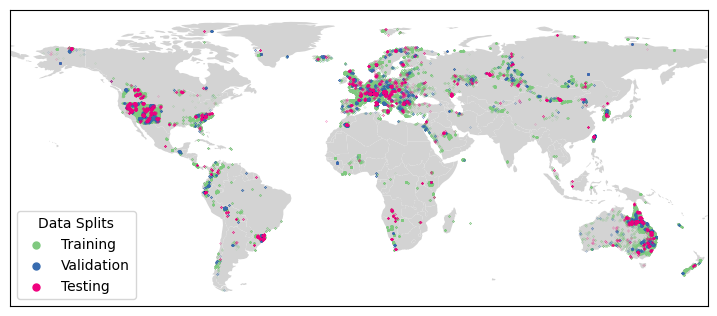

In [5]:
i_lon = data["tabular_names"].index("Longitude")
i_lat = data["tabular_names"].index("Latitude")
coordinates = data["tabular_x"][:, [i_lon, i_lat]]

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
world = world[world.geometry.centroid.y > -60]
fig, ax = plt.subplots(figsize=(9, 8))
world.plot(ax=ax, color='lightgray')

markersize = 0.01
palette = sns.color_palette("Accent")

gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[train_indices]])
gdf.plot(ax=ax, color=palette[0], markersize=markersize, label="Training")

gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[val_indices]])
gdf.plot(ax=ax, color=palette[4], markersize=markersize, label="Validation")

gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in coordinates[test_indices]])
gdf.plot(ax=ax, color=palette[5], markersize=markersize, label="Testing")

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

legend = ax.legend(loc='lower left', title="Data Splits")
for handle in legend.legend_handles:
    handle.set_sizes([25])  # increase the size of the markers in the legend
ax.margins(0)
ax.set_ylim((-63, 90))

plt.savefig("figures/splits.png", dpi=1000, bbox_inches='tight')
plt.savefig("figures/splits.pdf", bbox_inches='tight')
plt.show()

In [6]:
batch_size = 1024
test_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, data["x_test"], data["y_test"], data["satclip_embeddings_test"]),
                            batch_size=batch_size, shuffle=False)
val_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, data["x_val"], data["y_val"], data["satclip_embeddings_val"]),
                            batch_size=batch_size, shuffle=False)

In [7]:
def evaluate(model, dataloader, excluded_variables, indices_non_zeros_samples, satclip=True, handle_missing_values="mask", m=None, 
             species_subset=None, maxent_feature_transformer=None):
    
    with torch.no_grad():
        
        preds = []
        y = []
        for batch in dataloader:
            
            x_batch, y_batch, satclip_embeddings = batch
            
            if handle_missing_values == "mask":
                x_mask = (~torch.isnan(x_batch))
                if excluded_variables is not None:
                    x_mask[:, excluded_variables] = 0
                if satclip:
                    satclip_embeddings_mask = torch.tensor(np.ones(len(satclip_embeddings)))
                else:
                    satclip_embeddings_mask = torch.tensor(np.zeros(len(satclip_embeddings)))
                    
                y_pred = model(x_batch.to(device), satclip_embeddings.to(device), 
                               x_mask=x_mask.to(device), satclip_embeddings_mask=satclip_embeddings_mask.to(device)).detach()
            elif handle_missing_values == "mean":
                x_batch[torch.isnan(x_batch)] = 0
                if excluded_variables is not None:
                    x_batch[:, excluded_variables] = 0
                if not satclip:
                    satclip_embeddings = torch.Tensor(np.tile(satclip_means, (len(x_batch), 1)))
                y_pred = model(x_batch.to(device), satclip_embeddings.to(device)).detach()
            elif handle_missing_values == "median":
                medians = np.nanmedian(data["x_train"], axis=0)
                x_batch = np.where(np.isnan(x_batch), medians, x_batch)
                if excluded_variables is not None:
                    x_batch[:, excluded_variables] = np.where(True, medians[excluded_variables], x_batch[:, excluded_variables])
                if not satclip:
                    satclip_embeddings = torch.Tensor(np.tile(satclip_medians, (len(x_batch), 1)))
                x_batch = torch.tensor(x_batch)
                y_pred = model(x_batch.to(device), satclip_embeddings.to(device)).detach()
            elif handle_missing_values in ["marginal", "conditional"]:
                y_pred = model(x_batch.to(device), satclip_embeddings.to(device)).detach()
                y_pred = y_pred.reshape(-1, m, y_pred.shape[-1])
                y_pred = y_pred.mean(axis=1)
                y_batch = y_batch[::m,:]
            elif handle_missing_values == "mean_other_architecture":
                if excluded_variables is not None:
                    x_batch[:, excluded_variables] = 0
                if maxent_feature_transformer is not None:
                    x_batch = torch.Tensor(maxent_feature_transformer.transform(np.array(x_batch)))
                x_batch[torch.isnan(x_batch)] = 0
                y_pred = model(x_batch.to(device)).detach()
                
            preds.append(y_pred)
            y.append(y_batch)

        preds = torch.concatenate(preds, axis=0).float()
        y = torch.concatenate(y, axis=0).to(device).int()
        
        aucs = binary_auroc(preds[:, indices_non_zeros_samples].T, 
                           y[:, indices_non_zeros_samples].T, num_tasks=len(indices_non_zeros_samples)).cpu().numpy()
        if species_subset is not None:
            aucs = aucs[species_subset]
        auc = round(aucs.mean().item() * 100, 1)
        return aucs, auc, preds, y

In [8]:
tabular_names = np.array(data["tabular_names"])

wc_indices = list(range(19))
print("WorldClim:")
print(wc_indices)
print(tabular_names[wc_indices])

sg_indices = list(range(19, 27))
print("\nSoilGrids:")
print(sg_indices)
print(tabular_names[sg_indices])

loc_indices = list(range(27, 29))
print("\nLocation:")
print(loc_indices)
print(tabular_names[loc_indices])

topo_indices = list(range(29, 32))
print("\nTopography:")
print(topo_indices)
print(tabular_names[topo_indices])

meta_indices = list(range(32, 34))
print("\nMetadata:")
print(meta_indices)
print(tabular_names[meta_indices])

cover_indices = list(range(34, 45))
print("\nCover:")
print(cover_indices)
print(tabular_names[cover_indices])

height_indices = list(range(45, 52))
print("\nHeight:")
print(height_indices)
print(tabular_names[height_indices])

humans_indices = list(range(52, 61))
print("\nHumans influence:")
print(humans_indices)
print(tabular_names[humans_indices])

###

metaplus_indices = list(range(32, 52))
print("\nMetadata + Cover + Height:")
print(metaplus_indices)
print(tabular_names[metaplus_indices])

WorldClim:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
['bio_1' 'bio_2' 'bio_3' 'bio_4' 'bio_5' 'bio_6' 'bio_7' 'bio_8' 'bio_9'
 'bio_10' 'bio_11' 'bio_12' 'bio_13' 'bio_14' 'bio_15' 'bio_16' 'bio_17'
 'bio_18' 'bio_19']

SoilGrids:
[19, 20, 21, 22, 23, 24, 25, 26]
['ORCDRC' 'PHIHOX' 'CECSOL' 'BDTICM' 'CLYPPT' 'SLTPPT' 'SNDPPT' 'BLDFIE']

Location:
[27, 28]
['Longitude' 'Latitude']

Topography:
[29, 30, 31]
['Elevation' 'Slope' 'Aspect']

Metadata:
[32, 33]
['Location_uncertainty' 'Releve_area']

Cover:
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
['Cover_total' 'Cover_tree_layer' 'Cover_shrub_layer' 'Cover_herb_layer'
 'Cover_moss_layer' 'Cover_lichen_layer' 'Cover_algae_layer'
 'Cover_litter_layer' 'Cover_bare_rocks' 'Cover_cryptogams'
 'Cover_bare_soil']

Height:
[45, 46, 47, 48, 49, 50, 51]
['Height_trees_highest' 'Height_trees_lowest' 'Height_shrubs_highest'
 'Height_shrubs_lowest' 'Height_herbs_average' 'Height_herbs_lowest'
 'Height_herbs_highest']

Humans

In [9]:
avg_temp_index = [0]
satclip_index = [-1]

subsets = [avg_temp_index, 
           loc_indices, 
           satclip_index, 
           wc_indices, 
           wc_indices + sg_indices, 
           wc_indices + sg_indices + topo_indices,
           wc_indices + sg_indices + topo_indices + loc_indices,
           wc_indices + sg_indices + topo_indices + loc_indices + humans_indices,
           wc_indices + sg_indices + topo_indices + loc_indices + humans_indices + metaplus_indices,
           wc_indices + sg_indices + topo_indices + loc_indices + humans_indices + metaplus_indices + satclip_index]
all_indices = wc_indices + sg_indices + topo_indices + loc_indices + humans_indices + metaplus_indices

def evaluate_model(model, handle_missing_values="mask", m=100, species_subset=None):
    """
    Evaluate the model on different subsets of features for the given handle_missing_values strategy.
    """
    
    seed_everything(42)
    
    aucs = []
    for subset in subsets:
        if -1 in subset:
            subset = list(set(subset) - {-1})
            satclip = True
        else:
            satclip = False
        excluded_variables = list(set(all_indices) - set(subset))
        
        if handle_missing_values == "marginal":
            
            x_test_marginal = []
            y_test_marginal = []
            satclip_embeddings_test_marginal = []

            x_train = np.nan_to_num(data["x_train"], nan=0)
            x_test = np.nan_to_num(data["x_test"], nan=0)

            for i in range(len(x_test)):
                x_test_sample = np.tile(x_test[i], (m, 1))
                y_test_sample = np.tile(data["y_test"][i], (m, 1))
                indices = np.random.choice(len(x_train), m, replace=False)
                x = x_train[indices]
                x_test_sample[:,excluded_variables] = x[:,excluded_variables]
                
                if not satclip:
                    satclip_embeddings = data["satclip_embeddings_train"][indices]
                else:
                    satclip_embeddings = np.tile(data["satclip_embeddings_test"][i], (m, 1))
                
                x_test_marginal.append(x_test_sample)
                y_test_marginal.append(y_test_sample)
                satclip_embeddings_test_marginal.append(satclip_embeddings)

            x_test_marginal = np.concatenate(x_test_marginal, axis=0)
            y_test_marginal = np.concatenate(y_test_marginal, axis=0)
            satclip_embeddings_test_marginal = np.concatenate(satclip_embeddings_test_marginal, axis=0)

            data_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, x_test_marginal, y_test_marginal, satclip_embeddings_test_marginal),
                                        batch_size=int(1000/m)*m, shuffle=False)
        elif handle_missing_values == "conditional":
            
            x_test_conditional = []
            y_test_conditional = []
            satclip_embeddings_test_conditional = []

            x_train = np.nan_to_num(data["x_train"], nan=0)
            x_test = np.nan_to_num(data["x_test"], nan=0)

            for i in range(len(x_test)):
                x_test_sample = np.tile(x_test[i], (m, 1))
                y_test_sample = np.tile(data["y_test"][i], (m, 1))
                
                # find m nearest neighbors
                nn_indices = np.argsort(np.linalg.norm(x_train[:, subset] - x_test[i, subset], axis=1))[:m]                
                if not satclip:
                    satclip_embeddings = data["satclip_embeddings_train"][nn_indices]
                else:
                    satclip_embeddings = np.tile(data["satclip_embeddings_test"][i], (m, 1))
                    if len(subset) == 0: # if no tabular features are used, use satclip embeddings for nearest neighbors
                        nn_indices = np.argsort(np.linalg.norm(data["satclip_embeddings_train"] - data["satclip_embeddings_test"][i], axis=1))[:m]
                x_test_sample[:, excluded_variables] = x_train[nn_indices][:, excluded_variables]
                
                x_test_conditional.append(x_test_sample)
                y_test_conditional.append(y_test_sample)
                satclip_embeddings_test_conditional.append(satclip_embeddings)

            x_test_conditional = np.concatenate(x_test_conditional, axis=0)
            y_test_conditional = np.concatenate(y_test_conditional, axis=0)
            satclip_embeddings_test_conditional = np.concatenate(satclip_embeddings_test_conditional, axis=0)

            data_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, x_test_conditional, y_test_conditional, satclip_embeddings_test_conditional),
                                        batch_size=int(1000/m)*m, shuffle=False)
        else:
            m = None
            data_loader = test_loader
        
        _, auc_subset, _, _ = evaluate(model, data_loader, excluded_variables=excluded_variables, 
                                        indices_non_zeros_samples=indices_non_zeros_samples, 
                                        satclip=satclip, handle_missing_values=handle_missing_values, m=m,
                                        species_subset=species_subset)
        aucs.append(auc_subset)
        print(f"AUC: {auc_subset}, for subset: {subset}")
        
    latex_string = ""
    for auc in aucs:
        latex_string += f"{auc} & "
    print(latex_string[:-2])
    return aucs

In [10]:
model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()
evaluate_model(model, handle_missing_values="mask")

AUC: 85.1, for subset: [0]
AUC: 96.0, for subset: [27, 28]
AUC: 95.7, for subset: []
AUC: 97.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 98.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

[85.1, 96.0, 95.7, 97.1, 97.4, 97.5, 97.6, 97.6, 98.0, 98.0]

# Performance per epoch

In [11]:
for epoch in [5, 10, 25, 50, 100, 178, 500, 1000]:
    model.load_state_dict(torch.load(f"models/masksdm/epoch_{epoch}.pt"))
    model.eval()
    print(f"Epoch: {epoch}")
    evaluate_model(model, handle_missing_values="mask")

Epoch: 5
AUC: 82.0, for subset: [0]
AUC: 90.9, for subset: [27, 28]
AUC: 87.5, for subset: []
AUC: 95.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 95.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 95.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 96.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 96.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 96.2, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47

# Subsets of species per number of occurrences

In [ ]:
model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()

In [13]:
species_subset = data["y"][:, indices_non_zeros_samples].sum(axis=0) > 20
print(species_subset.sum())
evaluate_model(model, handle_missing_values="mask", species_subset=species_subset)

9009
AUC: 85.1, for subset: [0]
AUC: 96.0, for subset: [27, 28]
AUC: 95.7, for subset: []
AUC: 97.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 98.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48

[85.1, 96.0, 95.7, 97.1, 97.4, 97.5, 97.6, 97.6, 98.0, 98.0]

In [14]:
species_subset = data["y"][:, indices_non_zeros_samples].sum(axis=0) > 1000
print(species_subset.sum())
evaluate_model(model, handle_missing_values="mask", species_subset=species_subset)

228
AUC: 78.9, for subset: [0]
AUC: 89.2, for subset: [27, 28]
AUC: 90.0, for subset: []
AUC: 92.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 93.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 93.3, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 93.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 93.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 94.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,

[78.9, 89.2, 90.0, 92.1, 93.0, 93.3, 93.5, 93.5, 94.9, 94.9]

In [15]:
species_subset = (data["y"][:, indices_non_zeros_samples].sum(axis=0) <= 1000) & (data["y"][:, indices_non_zeros_samples].sum(axis=0) > 100)
print(species_subset.sum())
evaluate_model(model, handle_missing_values="mask", species_subset=species_subset)

3377
AUC: 84.9, for subset: [0]
AUC: 95.3, for subset: [27, 28]
AUC: 95.6, for subset: []
AUC: 96.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.3, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 97.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48

[84.9, 95.3, 95.6, 96.9, 97.3, 97.4, 97.5, 97.5, 97.9, 97.9]

In [16]:
species_subset = (data["y"][:, indices_non_zeros_samples].sum(axis=0) <= 100) & (data["y"][:, indices_non_zeros_samples].sum(axis=0) > 40)
print(species_subset.sum())
evaluate_model(model, handle_missing_values="mask", species_subset=species_subset)

2956
AUC: 85.6, for subset: [0]
AUC: 96.5, for subset: [27, 28]
AUC: 96.3, for subset: []
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.7, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 98.2, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48

[85.6, 96.5, 96.3, 97.5, 97.7, 97.8, 97.9, 97.9, 98.2, 98.2]

In [17]:
species_subset = (data["y"][:, indices_non_zeros_samples].sum(axis=0) <= 40) & (data["y"][:, indices_non_zeros_samples].sum(axis=0) > 20)
print(species_subset.sum())
evaluate_model(model, handle_missing_values="mask", species_subset=species_subset)

2448
AUC: 85.6, for subset: [0]
AUC: 96.7, for subset: [27, 28]
AUC: 95.5, for subset: []
AUC: 97.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.7, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 98.2, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48

[85.6, 96.7, 95.5, 97.4, 97.6, 97.7, 97.8, 97.8, 98.2, 98.2]

# Baselines

## Mean imputing

In [18]:
model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

evaluate_model(model, handle_missing_values="mean")

AUC: 69.6, for subset: [0]
AUC: 77.8, for subset: [27, 28]
AUC: 75.6, for subset: []
AUC: 88.7, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 91.3, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 91.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 95.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 95.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 95.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

[69.6, 77.8, 75.6, 88.7, 91.3, 91.8, 95.5, 95.5, 95.9, 97.8]

## Median imputing

In [19]:
model.load_state_dict(torch.load(f"models/median/epoch_14.pt"))
model.eval()

evaluate_model(model, handle_missing_values="median")

AUC: 73.5, for subset: [0]
AUC: 82.4, for subset: [27, 28]
AUC: 74.7, for subset: []
AUC: 89.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 91.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 91.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 95.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 95.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 96.3, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

[73.5, 82.4, 74.7, 89.4, 91.1, 91.6, 95.9, 95.8, 96.3, 97.9]

## Marginal imputing

Note that this approach is time-consuming at inference.

In [20]:
model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

evaluate_model(model, handle_missing_values="marginal", m=100)

AUC: 62.4, for subset: [0]
AUC: 79.8, for subset: [27, 28]
AUC: 82.1, for subset: []
AUC: 89.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 92.7, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 93.2, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 96.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 96.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 96.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

[62.4, 79.8, 82.1, 89.5, 92.7, 93.2, 96.1, 96.1, 96.6, 97.8]

## Conditional imputing

Note that this approach is time-consuming at inference.

In [21]:
model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

evaluate_model(model, handle_missing_values="conditional", m=5)

AUC: 72.6, for subset: [0]
AUC: 96.6, for subset: [27, 28]
AUC: 95.0, for subset: []
AUC: 96.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.2, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.0, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,

[72.6, 96.6, 95.0, 96.6, 97.0, 97.0, 97.2, 97.0, 97.6, 97.8]

## Oracle

In [22]:
subset_names = ["temp", "loc", "satclip", "wc", "wc_sg", "wc_sg_topo", "wc_sg_topo_loc", "wc_sg_topo_loc_hum", "wc_sg_topo_loc_hum_meta"]
best_epochs = [7, 326, 9, 27, 33, 33, 29, 24, 24]

aucs = []
for i, subset in enumerate(subsets):
    if i < len(subset_names):
        model.load_state_dict(torch.load(f"models/oracle/{subset_names[i]}_epoch_{best_epochs[i]}.pt"))
    else:
        model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
    model.eval()
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False
    _, auc, _, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples,
                            excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="mean")
    print(f"AUC: {auc}, for subset: {subset}")
    aucs.append(auc)
    
latex_string = ""
for auc in aucs:
    latex_string += f"{auc} & "
print(latex_string[:-2])


AUC: 86.3, for subset: [0]
AUC: 96.8, for subset: [27, 28]
AUC: 96.7, for subset: [-1]
AUC: 97.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.7, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 97.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28, 52, 53, 54, 55, 56, 57, 58, 59, 60, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

# Venn diagram

In [23]:
model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()

aucs = []
for i in [True, False]:
    for j in [True, False]:
        for k in [True, False]:
            for l in [True, False]:
                subset = []
                if i:
                    subset += wc_indices + sg_indices + topo_indices
                if j:
                    satclip = True
                else:
                    satclip = False
                if k:
                    subset += humans_indices
                if l:
                    subset += loc_indices
                excluded_variables = list(set(all_indices) - set(subset))
                _, auc, _, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples, 
                                        excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="mask")
                print(f"AUC: {auc}, for subset: {subset}")
                aucs.append(auc)
print(aucs[:-1])

AUC: 97.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 52, 53, 54, 55, 56, 57, 58, 59, 60, 27, 28]
AUC: 97.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 97.8, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 27, 28]
AUC: 97.7, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.6, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 52, 53, 54, 55, 56, 57, 58, 59, 60, 27, 28]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 52, 53, 54, 55, 56, 57, 58, 59, 60]
AUC: 97.6, for subset: [0, 1

In [24]:
model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()

temp_indices = range(0, 12)
prec_indices = range(12, 19)

aucs = []
for i in [True, False]:
    for j in [True, False]:
        for k in [True, False]:
            for l in [True, False]:
                subset = []
                if i:
                    subset += temp_indices
                if j:
                    subset += prec_indices
                if k:
                    subset += sg_indices
                if l:
                    subset += topo_indices
                excluded_variables = list(set(all_indices) - set(subset))
                _, auc, _, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples,
                                        excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="mask")
                print(f"AUC: {auc}, for subset: {subset}")
                aucs.append(auc)
print(aucs[:-1])

AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.4, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.3, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 29, 30, 31]
AUC: 97.1, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
AUC: 97.5, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 97.3, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 97.2, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 29, 30, 31]
AUC: 96.9, for subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
AUC: 96.5, for subset: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31]
AUC: 95.9, for subset: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
AUC: 93.2, for subset: [12, 13, 14, 

# Mean Squared Difference with Oracle

In [25]:
subset_names = ["temp", "loc", "satclip", "wc", "wc_sg", "wc_sg_topo", "wc_sg_topo_loc", "wc_sg_topo_loc_hum", "wc_sg_topo_loc_hum_meta"]
best_epochs = [7, 326, 9, 27, 33, 33, 29, 24, 24]

oracle_preds = np.zeros((len(subsets), data["y_test"].shape[0], data["y_test"].shape[1]))
for i, subset in enumerate(subsets):
    if i < len(subset_names):
        model.load_state_dict(torch.load(f"models/oracle/{subset_names[i]}_epoch_{best_epochs[i]}.pt"))
    else:
        model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))    
    model.eval()
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False
    _, _, preds, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples,
                              excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="mean")
    oracle_preds[i] = torch.sigmoid(preds).cpu().numpy()

In [26]:
# MaskSDM

model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()

maskSDM_preds = np.zeros((len(subsets), data["y_test"].shape[0], data["y_test"].shape[1]))
for i, subset in enumerate(subsets):
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False
    _, _, preds, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples,
                              excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="mask")
    maskSDM_preds[i] = torch.sigmoid(preds).cpu().numpy()

In [27]:
scores = np.square(oracle_preds - maskSDM_preds).mean(axis=(1, 2)).round(3)

latex_string = ""
for score in scores:
    latex_string += f"{score} & "

print(latex_string[:-2])

0.027 & 0.033 & 0.011 & 0.005 & 0.005 & 0.005 & 0.005 & 0.006 & 0.005 & 0.005 


In [28]:
# Mean imputing baseline

model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

mean_preds = np.zeros((len(subsets), data["y_test"].shape[0], data["y_test"].shape[1]))
for i, subset in enumerate(subsets):
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False
    _, _, preds, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples,
                              excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="mean")
    mean_preds[i] = torch.sigmoid(preds).cpu().numpy()

In [29]:
scores = np.square(oracle_preds - mean_preds).mean(axis=(1, 2)).round(3)

latex_string = ""
for score in scores:
    latex_string += f"{score} & "

print(latex_string[:-2])

0.133 & 0.026 & 0.031 & 0.027 & 0.023 & 0.022 & 0.016 & 0.018 & 0.016 & 0.0 


In [30]:
# Median imputing baseline

model.load_state_dict(torch.load(f"models/median/epoch_14.pt"))
model.eval()

median_preds = np.zeros((len(subsets), data["y_test"].shape[0], data["y_test"].shape[1]))
for i, subset in enumerate(subsets):
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False
    _, _, preds, _ = evaluate(model, test_loader, indices_non_zeros_samples=indices_non_zeros_samples, 
                              excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="median")
    median_preds[i] = torch.sigmoid(preds).cpu().numpy()

In [31]:
scores = np.square(oracle_preds - median_preds).mean(axis=(1, 2)).round(3)

latex_string = ""
for score in scores:
    latex_string += f"{score} & "

print(latex_string[:-2])

0.131 & 0.032 & 0.034 & 0.028 & 0.023 & 0.022 & 0.015 & 0.015 & 0.013 & 0.003 


In [ ]:
# Marginal imputing baseline

model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

m = 100

marginal_preds = np.zeros((len(subsets), data["y_test"].shape[0], data["y_test"].shape[1]))
for i, subset in enumerate(subsets):
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False
    x_test_marginal = []
    y_test_marginal = []
    satclip_embeddings_test_marginal = []

    x_train = np.nan_to_num(data["x_train"], nan=0)
    x_test = np.nan_to_num(data["x_test"], nan=0)

    for j in range(len(x_test)):
        x_test_sample = np.tile(x_test[j], (m, 1))
        y_test_sample = np.tile(data["y_test"][j], (m, 1))
        indices = np.random.choice(len(x_train), m, replace=False)
        x = x_train[indices]
        x_test_sample[:,excluded_variables] = x[:,excluded_variables]
        
        if not satclip:
            satclip_embeddings = data["satclip_embeddings_train"][indices]
        else:
            satclip_embeddings = np.tile(data["satclip_embeddings_test"][j], (m, 1))
        
        x_test_marginal.append(x_test_sample)
        y_test_marginal.append(y_test_sample)
        satclip_embeddings_test_marginal.append(satclip_embeddings)

    x_test_marginal = np.concatenate(x_test_marginal, axis=0)
    y_test_marginal = np.concatenate(y_test_marginal, axis=0)
    satclip_embeddings_test_marginal = np.concatenate(satclip_embeddings_test_marginal, axis=0)
    data_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, x_test_marginal, y_test_marginal, satclip_embeddings_test_marginal),
                                        batch_size=int(600/m)*m, shuffle=False)

    _, _, preds, _ = evaluate(model, data_loader, indices_non_zeros_samples=indices_non_zeros_samples,
                              excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="marginal", m=m)
    marginal_preds[i] = torch.sigmoid(preds).cpu().numpy()

In [ ]:
np.save("results/marginal_preds.npy", marginal_preds)

In [ ]:
marginal_preds = np.load("results/marginal_preds.npy")

In [ ]:
scores = np.square(oracle_preds - marginal_preds).mean(axis=(1, 2)).round(3)

latex_string = ""
for score in scores:
    latex_string += f"{score} & "

print(latex_string[:-2])

In [ ]:
# Conditional

model.load_state_dict(torch.load(f"models/mean/epoch_18.pt"))
model.eval()

m = 5

conditional_preds = np.zeros((len(subsets), data["y_test"].shape[0], data["y_test"].shape[1]))
for i, subset in enumerate(subsets):
    excluded_variables = list(set(all_indices) - set(subset))
    if -1 in subset:
        satclip = True
    else:
        satclip = False

    x_test_conditional = []
    y_test_conditional = []
    satclip_embeddings_test_conditional = []

    x_train = np.nan_to_num(data["x_train"], nan=0)
    x_test = np.nan_to_num(data["x_test"], nan=0)

    for j in range(len(x_test)):
        x_test_sample = np.tile(x_test[j], (m, 1))
        y_test_sample = np.tile(data["y_test"][j], (m, 1))
        
        # find m nearest neighbors
        nn_indices = np.argsort(np.linalg.norm(x_train[:, subset] - x_test[j, subset], axis=1))[:m]                
        if not satclip:
            satclip_embeddings = data["satclip_embeddings_train"][nn_indices]
        else:
            satclip_embeddings = np.tile(data["satclip_embeddings_test"][j], (m, 1))
            if len(subset) == 0: # if no tabular features are used, use satclip embeddings for nearest neighbors
                nn_indices = np.argsort(np.linalg.norm(data["satclip_embeddings_train"] - data["satclip_embeddings_test"][j], axis=1))[:m]
        x_test_sample[:, excluded_variables] = x_train[nn_indices][:, excluded_variables]
        
        x_test_conditional.append(x_test_sample)
        y_test_conditional.append(y_test_sample)
        satclip_embeddings_test_conditional.append(satclip_embeddings)

    x_test_conditional = np.concatenate(x_test_conditional, axis=0)
    y_test_conditional = np.concatenate(y_test_conditional, axis=0)
    satclip_embeddings_test_conditional = np.concatenate(satclip_embeddings_test_conditional, axis=0)

    data_loader = DataLoader(get_torch_dataset({"dataset": "splot"}, x_test_conditional, y_test_conditional, satclip_embeddings_test_conditional),
                                batch_size=int(600/m)*m, shuffle=False)
    
    _, _, preds, _ = evaluate(model, data_loader, excluded_variables=excluded_variables, satclip=satclip, handle_missing_values="conditional", m=m)
    conditional_preds[i] = torch.sigmoid(preds).cpu().numpy()

In [ ]:
np.save("results/conditional_preds.npy", conditional_preds)

In [ ]:
conditional_preds = np.load("results/conditional_preds.npy")
np.square(oracle_preds - conditional_preds).mean(axis=(1, 2)).round(3)

array([0.129, 0.009, 0.034, 0.008, 0.007, 0.007, 0.006, 0.008, 0.005,
       0.   ])

# Architecture

In [10]:
all_indices = wc_indices + sg_indices + topo_indices + loc_indices + humans_indices + metaplus_indices
avg_temp_index = [0]

def evaluate_architecture(model, handle_missing_values, maxent_feature_transformer=None):
    
    excluded_variables = [list(set(all_indices) - set(avg_temp_index)),
                          list(set(all_indices) - set(loc_indices)),
                          list(set(all_indices) - set(wc_indices)),
                          list(set(all_indices) - set(wc_indices) - set(sg_indices)),
                          list(set(all_indices) - set(wc_indices) - set(sg_indices) - set(topo_indices) - set(loc_indices))]
    aucs = []
    for excluded in excluded_variables:
        _, auc, _, _ = evaluate(model, test_loader, excluded, satclip=False, indices_non_zeros_samples=indices_non_zeros_samples, 
                                handle_missing_values=handle_missing_values, maxent_feature_transformer=maxent_feature_transformer)
        print(f"AUC: {auc}, for subset: {set(all_indices) - set(excluded)}")
        aucs.append(auc)
    
    # With all variables
    excluded_variables = list()
    t = time.time()
    _, auc, _, _ = evaluate(model, test_loader, excluded_variables, indices_non_zeros_samples=indices_non_zeros_samples, satclip=False, 
                            handle_missing_values=handle_missing_values, maxent_feature_transformer=maxent_feature_transformer)
    t = time.time() - t
    aucs.append(auc)
    print(f"AUC: {auc}, for subset: {set(all_indices)}")
    
    num_param = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {num_param}")
    
    print(f"Time: {t:.2f}s")
    
    latex_string = ""
    for auc in aucs:
        latex_string += f"{auc} & "
    
    print(f"{num_param:,} & {t:.2f} & " + latex_string[:-2])

In [11]:
# Linear

model = torch.nn.Linear(n_features, n_species).to(device)
model.load_state_dict(torch.load(f"models/linear/epoch_62.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 69.8, for subset: {0}
AUC: 78.2, for subset: {27, 28}
AUC: 88.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 93.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 95.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 96.2, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 789756
Time: 0.31s
789,756 & 0.31 & 69.8 & 78.2 & 88.4 & 93.4 & 95.8 & 96.2 


In [12]:
# Maxent LHP

maxent_feature_transformer = MaxentFeatureTransformer(["linear", "hinge", "product"])
n_features_augmented = maxent_feature_transformer.fit_transform(data["x_train"]).shape[1]
print(f"Number of features: {n_features_augmented}")

model = torch.nn.Linear(n_features_augmented, n_species).to(device)
model.load_state_dict(torch.load(f"models/maxent_LHP/epoch_27.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture", maxent_feature_transformer=maxent_feature_transformer)

Number of features: 2989
AUC: 81.4, for subset: {0}
AUC: 87.7, for subset: {27, 28}
AUC: 94.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 95.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 96.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 95.7, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 38086620
Time: 0.53s
38,086,620 & 0.53 & 81.4 & 87.7 & 94.6 & 95.8 & 96.6 & 95.7 


In [13]:
# Maxent LHPTQ

maxent_feature_transformer = MaxentFeatureTransformer(feature_types=["linear", "hinge", "threshold", "quadratic", "product"])
n_features_augmented = maxent_feature_transformer.fit_transform(data["x_train"]).shape[1]
print(f"Number of features: {n_features_augmented}")

model = torch.nn.Linear(n_features_augmented, n_species).to(device)
model.load_state_dict(torch.load(f"models/maxent_LHPTQ/epoch_14.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture", maxent_feature_transformer=maxent_feature_transformer)

Number of features: 3660
AUC: 83.6, for subset: {0}
AUC: 90.3, for subset: {27, 28}
AUC: 95.1, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 95.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 96.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 96.0, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 46633818
Time: 0.56s
46,633,818 & 0.56 & 83.6 & 90.3 & 95.1 & 95.9 & 96.6 & 96.0 


In [14]:
# MLP 7 layers

d_hidden = 192
n_layers = 7
dropout = 0.1

model = MLP(d_in=n_features, d_hidden=d_hidden, d_out=n_species, 
            n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/mlp_7/epoch_121.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 68.7, for subset: {0}
AUC: 74.2, for subset: {27, 28}
AUC: 86.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 87.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 97.0, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 97.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 2692674
Time: 0.28s
2,692,674 & 0.28 & 68.7 & 74.2 & 86.8 & 87.8 & 97.0 & 97.4 


In [15]:
# MLP 21 layers

d_hidden = 192
n_layers = 21
dropout = 0.1

model = MLP(d_in=n_features, d_hidden=d_hidden, d_out=n_species, 
            n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/mlp_21/epoch_33.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 41.0, for subset: {0}
AUC: 63.3, for subset: {27, 28}
AUC: 78.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 78.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 91.5, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 92.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 3211458
Time: 0.29s
3,211,458 & 0.29 & 41.0 & 63.3 & 78.3 & 78.6 & 91.5 & 92.3 


In [16]:
# Resnet 7 layers

d_hidden = 192
n_layers = 7
dropout = 0.1

model = ResNet(d_in=n_features, d_hidden=d_hidden, d_out=n_species, 
               n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/resnet_7/epoch_29.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 67.6, for subset: {0}
AUC: 78.6, for subset: {27, 28}
AUC: 90.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 93.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 97.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 97.7, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 2992194
Time: 0.29s
2,992,194 & 0.29 & 67.6 & 78.6 & 90.9 & 93.8 & 97.3 & 97.7 


In [17]:
# Resnet 21 layers

d_hidden = 192
n_layers = 21
dropout = 0.1

model = ResNet(d_in=n_features, d_hidden=d_hidden, d_out=n_species,
               n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/resnet_21/epoch_21.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 70.6, for subset: {0}
AUC: 80.1, for subset: {27, 28}
AUC: 91.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 94.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 97.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 97.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 4035138
Time: 0.31s
4,035,138 & 0.31 & 70.6 & 80.1 & 91.9 & 94.4 & 97.4 & 97.8 


In [18]:
# MaskSDM 3 blocks
d_hidden = 192
n_heads = 8
n_blocks = 3
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)
model.load_state_dict(torch.load(f"models/masksdm/3_blocks/epoch_209.pt"))
model.eval()

evaluate_architecture(model, "mask")

AUC: 85.5, for subset: {0}
AUC: 95.9, for subset: {27, 28}
AUC: 97.0, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 97.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 97.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 97.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 4390578
Time: 0.70s
4,390,578 & 0.70 & 85.5 & 95.9 & 97.0 & 97.3 & 97.6 & 97.9 


In [19]:
# MaskSDM 7 blocks
d_hidden = 192
n_heads = 8
n_blocks = 7
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)
model.load_state_dict(torch.load(f"models/masksdm/epoch_178.pt"))
model.eval()

evaluate_architecture(model, "mask")

AUC: 85.1, for subset: {0}
AUC: 96.0, for subset: {27, 28}
AUC: 97.1, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 97.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 97.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
AUC: 98.0, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60}
Number of parameters: 5381554
Time: 1.10s
5,381,554 & 1.10 & 85.1 & 96.0 & 97.1 & 97.4 & 97.6 & 98.0 


## GeoPlant

In [20]:
# Load GeoPlant data

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mode = "extrapolate"

data = get_data("geoplant")

data["y"] = data["y"][:, data["y"].sum(axis=0) > 20]

n_features = data["tabular_x"].shape[1]
n_samples, n_species = data["y"].shape

train_indices, val_indices, test_indices = get_split_indices(data, mode=mode)

data["x_train"], data["y_train"] = data["tabular_x"][train_indices], data["y"][train_indices]
data["x_val"], data["y_val"] = data["tabular_x"][val_indices], data["y"][val_indices]
data["x_test"], data["y_test"] = data["tabular_x"][test_indices], data["y"][test_indices]
data["satclip_embeddings_train"] = data["satclip_embeddings"][train_indices]
data["satclip_embeddings_test"] = data["satclip_embeddings"][test_indices]
data["satclip_embeddings_val"] = data["satclip_embeddings"][val_indices]

train_mean = np.nanmean(data["x_train"], axis=0)
train_std = np.nanstd(data["x_train"], axis=0)
data["x_train"] = (data["x_train"] - train_mean)/(train_std + 0.0001)
data["x_test"] = (data["x_test"] - train_mean)/(train_std + 0.0001)
data["x_val"] = (data["x_val"] - train_mean)/(train_std + 0.0001)

medians = np.nanmedian(data["x_train"], axis=0)
satclip_medians = np.median(data["satclip_embeddings_train"], axis=0)
satclip_means = np.mean(data["satclip_embeddings_train"], axis=0)

indices_non_zeros_samples = np.intersect1d(np.intersect1d(np.sum(data["y_train"], axis=0).nonzero()[0], np.sum(data["y_val"], axis=0).nonzero()[0]),
                                                            np.sum(data["y_test"], axis=0).nonzero()[0]).tolist()

In [21]:
batch_size = 1024
test_loader = DataLoader(get_torch_dataset({"dataset": "geoplant"}, data["x_test"], data["y_test"], data["satclip_embeddings_test"]),
                            batch_size=batch_size, shuffle=False)
val_loader = DataLoader(get_torch_dataset({"dataset": "geoplant"}, data["x_val"], data["y_val"], data["satclip_embeddings_val"]),
                            batch_size=batch_size, shuffle=False)

In [22]:
geoplant_wc_indices = list(range(0, 19))
geoplant_sg_indices = list(range(19, 27))
geoplant_loc_indices = list(range(27, 29))
geoplant_elevation_indices = list(range(29, 30))
geoplant_metaplus_indices = list(range(30, 32))
geoplant_human_indices = list(range(32, 41))

geoplant_all_indices = geoplant_wc_indices + geoplant_sg_indices + geoplant_loc_indices + \
                            geoplant_elevation_indices + geoplant_metaplus_indices + geoplant_human_indices
avg_temp_index = [0]

def evaluate_architecture(model, handle_missing_values, maxent_feature_transformer=None, indices_non_zeros_samples=indices_non_zeros_samples):
    
    excluded_variables = [list(set(geoplant_all_indices) - set(avg_temp_index)),
                        list(set(geoplant_all_indices) - set(geoplant_loc_indices)),
                        list(set(geoplant_all_indices) - set(geoplant_wc_indices)),
                        list(set(geoplant_all_indices) - set(geoplant_wc_indices) - set(geoplant_sg_indices)),
                        list(set(geoplant_all_indices) - set(geoplant_wc_indices) - set(geoplant_sg_indices) - set(geoplant_elevation_indices) - set(geoplant_loc_indices))]
    
    aucs = []
    for excluded in excluded_variables:
        _, auc, _, _ = evaluate(model, test_loader, excluded, indices_non_zeros_samples=indices_non_zeros_samples, satclip=False,
                                handle_missing_values=handle_missing_values, maxent_feature_transformer=maxent_feature_transformer)
        print(f"AUC: {auc}, for subset: {set(geoplant_all_indices) - set(excluded)}")
        aucs.append(auc)
    
    # With all variables
    excluded_variables = list()
    t = time.time()
    _, auc, _, _ = evaluate(model, test_loader, excluded_variables, indices_non_zeros_samples=indices_non_zeros_samples, satclip=False, 
                            handle_missing_values=handle_missing_values, maxent_feature_transformer=maxent_feature_transformer)
    t = time.time() - t
    aucs.append(auc)
    print(f"AUC: {auc}, for subset: {set(geoplant_all_indices)}")
    
    num_param = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {num_param}")
    
    print(f"Time: {t:.2f}s")
    
    latex_string = ""
    for auc in aucs:
        latex_string += f"{auc} & "
    
    print(f"{num_param:,} & {t:.2f} & " + latex_string[:-2])

In [23]:
# Linear

model = torch.nn.Linear(n_features, n_species).to(device)
model.load_state_dict(torch.load(f"models/geoplant/linear/epoch_42.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 65.6, for subset: {0}
AUC: 64.9, for subset: {27, 28}
AUC: 82.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 85.0, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 86.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 87.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 95675
Time: 0.26s
95,675 & 0.26 & 65.6 & 64.9 & 82.6 & 85.0 & 86.3 & 87.4 


In [24]:
# Maxent LHP

maxent_feature_transformer = MaxentFeatureTransformer(["linear", "hinge", "product"])
n_features_augmented = maxent_feature_transformer.fit_transform(data["x_train"]).shape[1]
print(f"Number of features: {n_features_augmented}")

model = torch.nn.Linear(n_features_augmented, n_species).to(device)
model.load_state_dict(torch.load(f"models/geoplant/maxent_LHP/epoch_14.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture", maxent_feature_transformer=maxent_feature_transformer)

Number of features: 1659
AUC: 71.5, for subset: {0}
AUC: 67.8, for subset: {27, 28}
AUC: 82.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 83.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 85.5, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 85.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 3693500
Time: 0.37s
3,693,500 & 0.37 & 71.5 & 67.8 & 82.9 & 83.6 & 85.5 & 85.4 


In [25]:
# Maxent LHPTQ

maxent_feature_transformer = MaxentFeatureTransformer(feature_types=["linear", "hinge", "threshold", "quadratic", "product"])
n_features_augmented = maxent_feature_transformer.fit_transform(data["x_train"]).shape[1]
print(f"Number of features: {n_features_augmented}")

model = torch.nn.Linear(n_features_augmented, n_species).to(device)
model.load_state_dict(torch.load(f"models/geoplant/maxent_LHPTQ/epoch_7.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture", maxent_feature_transformer=maxent_feature_transformer)

Number of features: 2121
AUC: 72.1, for subset: {0}
AUC: 70.2, for subset: {27, 28}
AUC: 83.1, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 83.5, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 85.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 85.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 4721450
Time: 0.43s
4,721,450 & 0.43 & 72.1 & 70.2 & 83.1 & 83.5 & 85.8 & 85.6 


In [26]:
# MLP 7 layers

d_hidden = 192
n_layers = 7
dropout = 0.1

model = MLP(d_in=n_features, d_hidden=d_hidden, d_out=n_species, 
            n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/geoplant/mlp_7/epoch_37.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 65.0, for subset: {0}
AUC: 64.8, for subset: {27, 28}
AUC: 83.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 85.7, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 87.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 88.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 660017
Time: 0.26s
660,017 & 0.26 & 65.0 & 64.8 & 83.3 & 85.7 & 87.9 & 88.4 


In [27]:
# MLP 21 layers

d_hidden = 192
n_layers = 21
dropout = 0.1

model = MLP(d_in=n_features, d_hidden=d_hidden, d_out=n_species, 
            n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/geoplant/mlp_21/epoch_29.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 57.5, for subset: {0}
AUC: 53.8, for subset: {27, 28}
AUC: 72.9, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 78.1, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 80.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 82.5, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 1178801
Time: 0.24s
1,178,801 & 0.24 & 57.5 & 53.8 & 72.9 & 78.1 & 80.8 & 82.5 


In [28]:
# ResNet 7 layers

d_hidden = 192
n_layers = 7
dropout = 0.1

model = ResNet(d_in=n_features, d_hidden=d_hidden, d_out=n_species,
               n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/geoplant/resnet_7/epoch_9.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 66.9, for subset: {0}
AUC: 67.9, for subset: {27, 28}
AUC: 84.2, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 86.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 88.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 89.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 959537
Time: 0.38s
959,537 & 0.38 & 66.9 & 67.9 & 84.2 & 86.4 & 88.4 & 89.3 


In [29]:
# ResNet 21 layers

d_hidden = 192
n_layers = 21
dropout = 0.1

model = ResNet(d_in=n_features, d_hidden=d_hidden, d_out=n_species,
               n_layers=n_layers, dropout=dropout).to(device)
model.load_state_dict(torch.load(f"models/geoplant/resnet_21/epoch_9.pt"))
model.eval()

evaluate_architecture(model, "mean_other_architecture")

AUC: 68.2, for subset: {0}
AUC: 63.3, for subset: {27, 28}
AUC: 85.5, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 87.1, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 88.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 89.3, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 2002481
Time: 0.27s
2,002,481 & 0.27 & 68.2 & 63.3 & 85.5 & 87.1 & 88.6 & 89.3 


In [30]:
# MaskSDM 3 blocks
d_hidden = 192
n_heads = 8
n_blocks = 3
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)
model.load_state_dict(torch.load(f"models/geoplant/masksdm/3_blocks/epoch_51.pt"))
model.eval()

evaluate_architecture(model, "mask")

AUC: 79.6, for subset: {0}
AUC: 80.9, for subset: {27, 28}
AUC: 87.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 88.4, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 88.7, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 89.7, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 2006801
Time: 0.45s
2,006,801 & 0.45 & 79.6 & 80.9 & 87.4 & 88.4 & 88.7 & 89.7 


In [31]:
# MaskSDM 7 blocks
d_hidden = 192
n_heads = 8
n_blocks = 7
dropout = 0.1

feature_tokenizer = FeatureTokenizer(n_features=n_features, d_token=d_hidden)
transformer_encoder = TransformerEncoder(d_token=d_hidden, n_blocks=n_blocks, n_heads=n_heads, dropout=dropout)
model = FTTransformer(feature_tokenizer=feature_tokenizer, transformer_encoder=transformer_encoder, 
                      d_hidden=d_hidden, d_out=n_species).to(device)
model.load_state_dict(torch.load(f"models/geoplant/masksdm/epoch_52.pt"))
model.eval()

evaluate_architecture(model, "mask")

AUC: 80.0, for subset: {0}
AUC: 80.8, for subset: {27, 28}
AUC: 87.7, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
AUC: 88.6, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
AUC: 88.8, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
AUC: 89.5, for subset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}
Number of parameters: 2997777
Time: 0.75s
2,997,777 & 0.75 & 80.0 & 80.8 & 87.7 & 88.6 & 88.8 & 89.5 
